Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 217ms/step - loss: 37.9849 - val_loss: 30.3783
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 102s 217ms/step - loss: 30.3810 - val_loss: 29.7611
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 214ms/step - loss: 29.8468 - val_loss: 29.4137
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 213ms/step - loss: 29.4598 - val_loss: 29.0292
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 100s 213ms/step - loss: 29.2443 - val_loss: 29.0570
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 217ms/step - loss: 29.0838 - val_loss: 28.8005
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 214ms/step - loss: 28.9128 - val_loss: 28.5007
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 214ms/step - loss: 28.7311 - val_loss: 28.7326
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 212ms/step - loss: 28.6128 - val_loss: 28.4556
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 213ms/step - loss: 28.4822 - val_loss: 28.2774
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 215ms/step - loss: 28.4651 - val_l

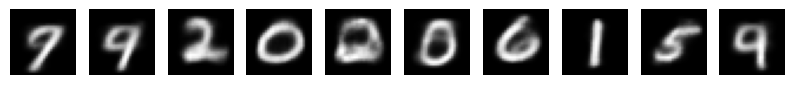

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))  # Reshape to (batch_size, 28, 28, 1)
x_test = np.reshape(x_test, (-1, 28, 28, 1))    # Reshape to (batch_size, 28, 28, 1)

# Define the architecture of the VAE

# Encoder
latent_dim = 2  # Latent space dimension

inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)

# Latent space
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

# Decoder model
decoder = models.Model(latent_inputs, outputs, name="decoder")

# VAE model class
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Encode the inputs to get z_mean, z_log_var, and z
        z_mean, z_log_var, z = self.encoder(inputs)

        # Decode the latent variables z to get reconstructed images
        reconstructed = self.decoder(z)

        # Flatten inputs and reconstructed images for loss computation
        inputs_flattened = tf.reshape(inputs, [-1, 28 * 28])
        reconstructed_flattened = tf.reshape(reconstructed, [-1, 28 * 28])

        # Compute VAE loss
        xent_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(inputs_flattened, reconstructed_flattened),
                axis=-1,
            )
        )

        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        )

        vae_loss = xent_loss + kl_loss
        self.add_loss(vae_loss)

        return reconstructed


# Encoder model
encoder = models.Model(inputs, [z_mean, z_log_var, z], name="encoder")

# Create the VAE model
vae = VAE(encoder=encoder, decoder=decoder)

# Compile the VAE model
vae.compile(optimizer='rmsprop')

# Train the VAE for 20 epochs
vae.fit(x_train, x_train, epochs=20, batch_size=128, validation_data=(x_test, x_test))

# Generate new digits
def generate_digits(n=10):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(n, latent_dim))
    generated_images = vae.decoder.predict(random_latent_vectors)

    # Plot the generated images
    plt.figure(figsize=(n, 1))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

# Generate and display 10 new digits
generate_digits(10)